In [1]:
import tensorflow as tf
from tensorflow import keras 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense,Dropout, BatchNormalization

from keras import optimizers
from keras import regularizers
from keras.models import Sequential

D:\Anaconda\envs\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data = pd.read_csv("D:/DL_data/Taxi/train.csv",nrows=100000)
test_data = pd.read_csv("D:/DL_data/Taxi/test.csv")

In [3]:
train_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


    经纬度400多太大，是噪音，需要在纽约城市的经纬度范围内进行缩减，去除噪音
    有些金额为负数，不符合逻辑且有些起点终点坐标一样

In [5]:
test_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [6]:
min_latitude = min(test_data.dropoff_latitude.min(),test_data.pickup_latitude.min())
min_longitude = min(test_data.dropoff_longitude.min(),test_data.pickup_longitude.min())
max_longitude = max(test_data.pickup_longitude.max(),test_data.dropoff_longitude.max())
max_latitude = max(test_data.dropoff_latitude.max(),test_data.pickup_latitude.max())

def erase_noise(train_data):
    train_data = train_data[(train_data.pickup_latitude>=min_latitude) &( train_data.pickup_latitude<=max_latitude)]
    train_data = train_data[(train_data.pickup_longitude>=min_longitude) & (train_data.pickup_longitude<=max_longitude)]
    train_data = train_data[(train_data.dropoff_latitude>=min_latitude) & (train_data.dropoff_latitude<=max_latitude)]
    train_data = train_data[(train_data.dropoff_longitude>=min_longitude) & (train_data.dropoff_longitude<=max_longitude)]
    train_data = train_data[train_data.fare_amount>0]
    train_data = train_data[(train_data.pickup_latitude!=train_data.dropoff_latitude)&(train_data.dropoff_longitude!=train_data.pickup_longitude)]
    return train_data

将训练数据train_data中超出纽约市的所有经纬度去除，以test_data中的最大最小经纬度为矩形对train_data进行筛选

In [7]:
train_data = erase_noise(train_data)

In [8]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,96726.000000,96726.000000,96726.000000,96726.000000,96726.000000,96726.000000
mean,11.333160,-73.975357,40.751113,-73.974257,40.751520,1.674720
std,9.529301,0.036269,0.028151,0.035171,0.031294,1.300531
min,0.010000,-74.248263,40.572183,-74.241953,40.571222,0.000000
25%,6.000000,-73.992277,40.736693,-73.991402,40.735794,1.000000
50%,8.500000,-73.982100,40.753550,-73.980459,40.753988,1.000000
75%,12.500000,-73.968445,40.767681,-73.965316,40.768495,2.000000
max,165.000000,-73.085745,41.650000,-73.085764,41.543217,6.000000


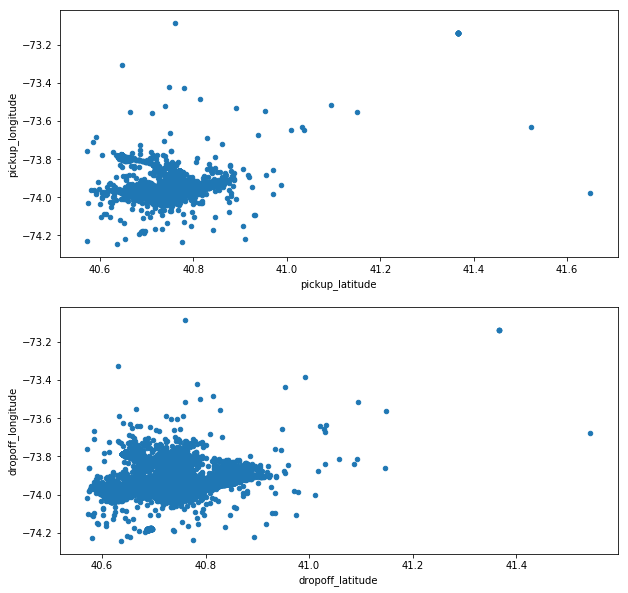

In [9]:
fig,axarr = plt.subplots(2,1,figsize=(10,10))
train_data.plot.scatter(x='pickup_latitude',y='pickup_longitude',ax=axarr[0])
train_data.plot.scatter(x='dropoff_latitude',y='dropoff_longitude',ax=axarr[1])

In [10]:
train_data['manhatton'] = abs(train_data.pickup_latitude-train_data.dropoff_latitude)+abs(train_data.pickup_longitude-train_data.dropoff_longitude)

In [11]:
test_data['manhatton'] = abs(test_data.pickup_latitude-test_data.dropoff_latitude)+abs(test_data.pickup_longitude-test_data.dropoff_longitude)

In [12]:
train_data.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhatton
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.011742
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.107481
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.019212
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.029386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.027194
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,0.054675
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,0.019380
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,0.061885
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,0.018299
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,0.035147


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96726 entries, 0 to 99999
Data columns (total 9 columns):
key                  96726 non-null object
fare_amount          96726 non-null float64
pickup_datetime      96726 non-null object
pickup_longitude     96726 non-null float64
pickup_latitude      96726 non-null float64
dropoff_longitude    96726 non-null float64
dropoff_latitude     96726 non-null float64
passenger_count      96726 non-null int64
manhatton            96726 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 7.4+ MB


In [14]:
train_data['time']=pd.to_datetime(train_data.pickup_datetime)

In [15]:
train_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhatton,time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.011742,2009-06-15 17:26:21
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.107481,2010-01-05 16:52:16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.019212,2011-08-18 00:35:00
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.029386,2012-04-21 04:30:42
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.027194,2010-03-09 07:51:00


In [16]:
train_data.groupby(['passenger_count']).fare_amount.mean()

passenger_count
0     9.187395
1    11.186791
2    11.862837
3    11.399571
4    11.753647
5    11.315886
6    12.400332
Name: fare_amount, dtype: float64

人数基本对价格没有影响

In [17]:
train_data.time

0       2009-06-15 17:26:21
1       2010-01-05 16:52:16
2       2011-08-18 00:35:00
3       2012-04-21 04:30:42
4       2010-03-09 07:51:00
5       2011-01-06 09:50:45
6       2012-11-20 20:35:00
7       2012-01-04 17:22:00
8       2012-12-03 13:10:00
9       2009-09-02 01:11:00
10      2012-04-08 07:30:50
12      2009-11-06 01:04:03
13      2013-07-02 19:54:00
14      2011-04-05 17:11:05
16      2014-02-19 07:22:00
17      2009-07-22 16:08:00
18      2010-07-07 14:52:00
19      2014-12-06 20:36:22
20      2010-09-07 13:18:00
21      2013-02-12 12:15:46
22      2009-08-06 18:17:23
23      2010-12-06 12:29:00
24      2009-12-10 15:37:00
25      2011-06-21 16:15:00
27      2011-06-28 19:47:00
28      2012-05-04 06:11:20
29      2013-08-11 00:52:00
30      2014-02-19 16:03:00
31      2015-06-21 21:46:34
32      2009-01-09 16:10:00
                ...        
99968   2012-11-11 15:37:00
99969   2009-01-03 12:30:00
99970   2010-06-30 21:37:56
99972   2012-12-04 09:03:20
99973   2013-05-06 1

In [18]:
train_data['hour'] = train_data.time.map(lambda x : x.hour)

train_data['year'] = train_data.time.map(lambda x : x.year)
train_data['month'] = train_data.time.map(lambda x : x.month)

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96726 entries, 0 to 99999
Data columns (total 13 columns):
key                  96726 non-null object
fare_amount          96726 non-null float64
pickup_datetime      96726 non-null object
pickup_longitude     96726 non-null float64
pickup_latitude      96726 non-null float64
dropoff_longitude    96726 non-null float64
dropoff_latitude     96726 non-null float64
passenger_count      96726 non-null int64
manhatton            96726 non-null float64
time                 96726 non-null datetime64[ns]
hour                 96726 non-null int64
year                 96726 non-null int64
month                96726 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(4), object(2)
memory usage: 10.3+ MB


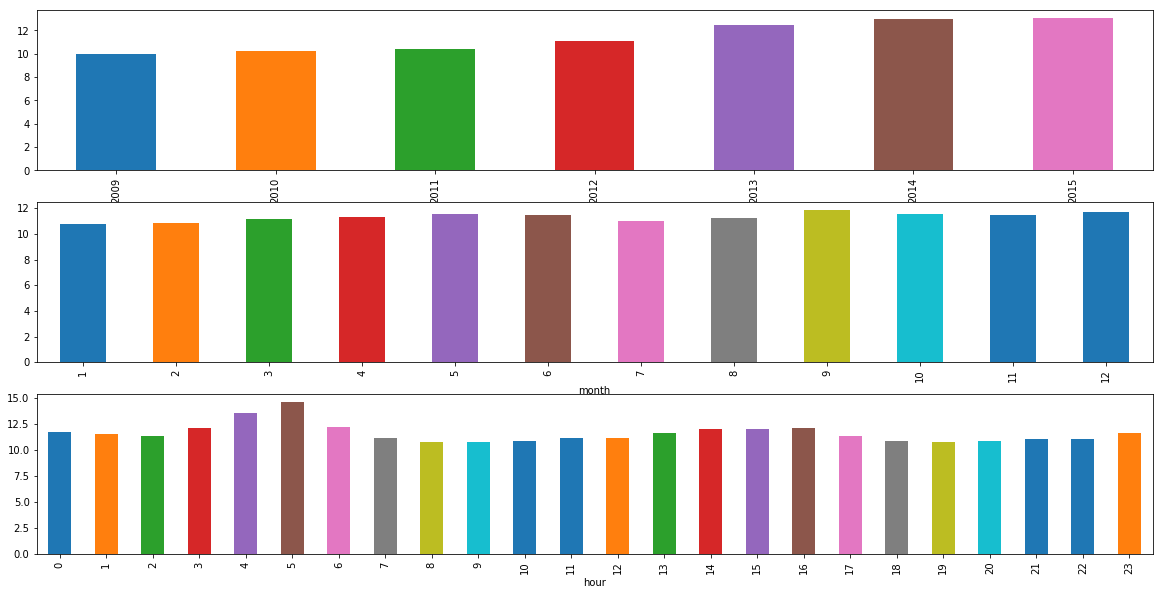

In [20]:
fig,axr = plt.subplots(3,1,figsize=(20,10))
train_data.groupby('year').fare_amount.mean().plot.bar(ax=axr[0])
train_data.groupby('month').fare_amount.mean().plot.bar(ax=axr[1])
train_data.groupby('hour').fare_amount.mean().plot.bar(ax=axr[2])

我们可以看出：
1.随着年份增加物价上涨
2.月份还看不出来，需要放大
3.3点-5点价格上升

In [21]:
train_data.groupby('month').fare_amount.describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,8784.0,10.776405,8.964296,2.50,5.7,8.0,12.0000,136.33
2,8338.0,10.863913,8.988024,0.01,6.0,8.1,12.1000,136.00
3,8979.0,11.142764,9.212912,2.50,6.0,8.5,12.5000,160.77
4,8826.0,11.311647,9.533954,2.50,6.0,8.5,12.9000,160.00
5,8948.0,11.578297,9.856968,0.01,6.1,8.5,13.0000,160.00
6,8754.0,11.501451,9.345474,2.50,6.1,8.5,13.0000,96.25
7,7185.0,11.019773,9.127115,2.50,6.0,8.1,12.5000,145.58
8,6883.0,11.225704,9.740334,2.50,6.0,8.1,12.5000,165.00
9,7344.0,11.868621,10.099501,2.50,6.1,8.5,13.3000,130.00


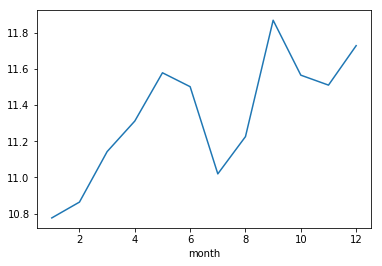

In [22]:
train_data.groupby('month').fare_amount.mean().plot.line()

月份还是有一点影响的= =

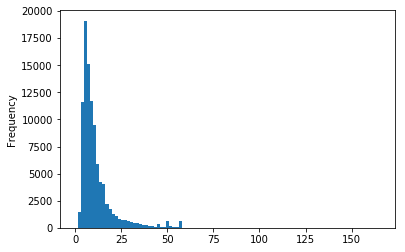

In [23]:
train_data.fare_amount.plot.hist(bins=100)

50左右价格频率有点不自然的高，于是放大

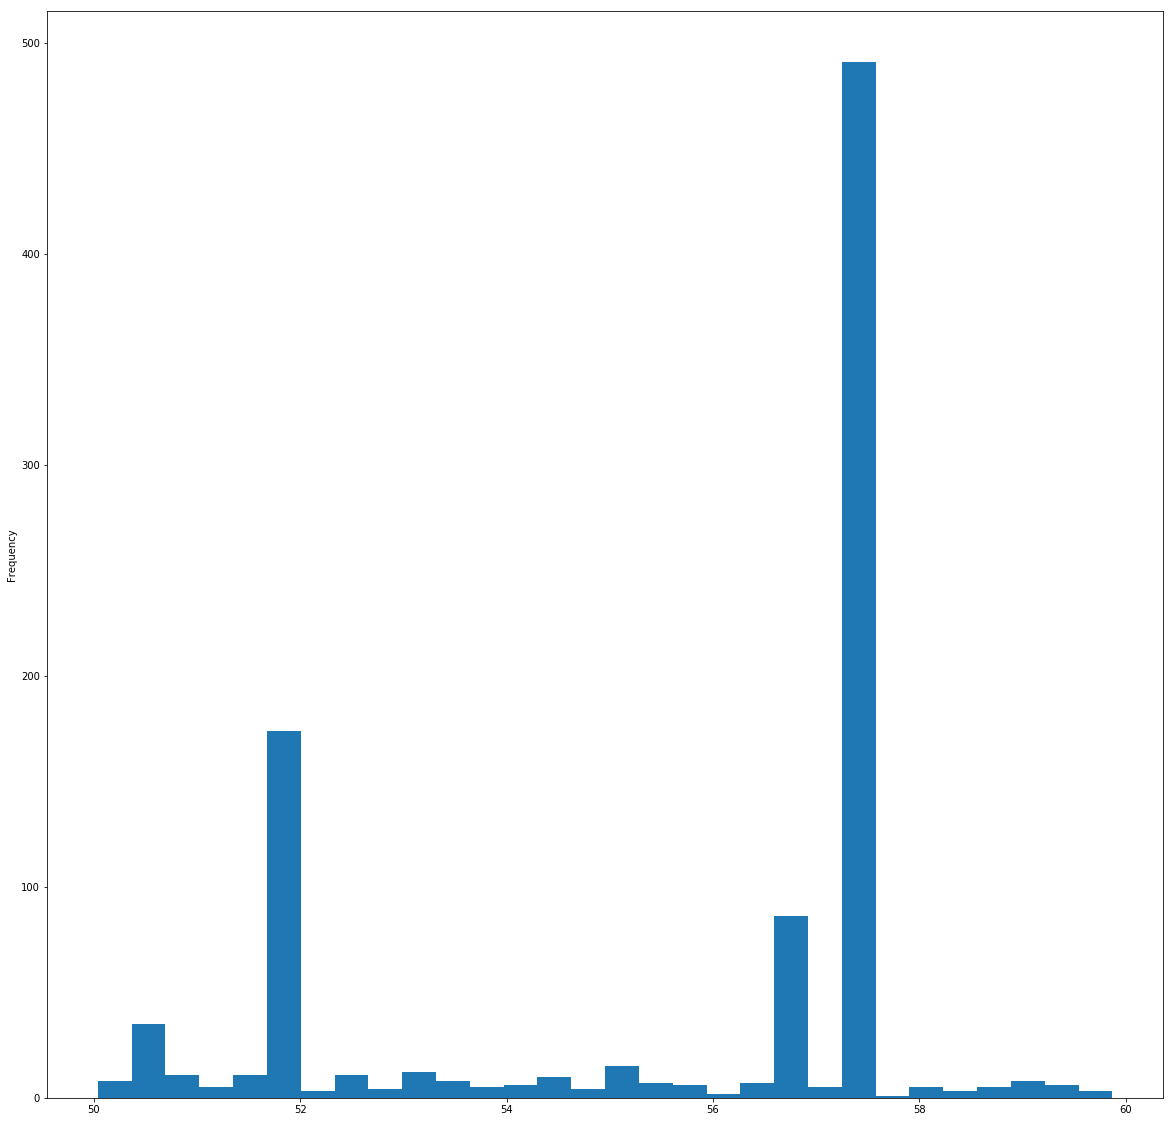

In [24]:
train_data[(train_data.fare_amount>50) & (train_data.fare_amount<60)].fare_amount.plot.hist(bins=30,figsize=(20,20))

In [25]:
train_data[(train_data.fare_amount>56) & (train_data.fare_amount<58)].sort_values(by=['dropoff_longitude'])

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhatton,time,hour,year,month
88450,2012-02-14 15:30:47.0000004,57.50,2012-02-14 15:30:47 UTC,-73.999767,40.727138,-74.181775,40.687686,1,0.221460,2012-02-14 15:30:47,15,2012,2
41786,2011-10-20 14:22:08.0000004,56.70,2011-10-20 14:22:08 UTC,-73.974091,40.756013,-74.177667,40.690358,1,0.269231,2011-10-20 14:22:08,14,2011,10
6211,2012-09-01 07:06:24.0000003,57.00,2012-09-01 07:06:24 UTC,-74.009649,40.705884,-74.177489,40.695215,1,0.178509,2012-09-01 07:06:24,7,2012,9
10231,2009-10-30 10:32:00.000000181,57.10,2009-10-30 10:32:00 UTC,-74.007712,40.715067,-74.177318,40.695062,2,0.189611,2009-10-30 10:32:00,10,2009,10
37875,2015-03-30 16:52:08.0000006,56.50,2015-03-30 16:52:08 UTC,-73.783989,40.648590,-74.020859,40.631283,1,0.254177,2015-03-30 16:52:08,16,2015,3
44297,2015-06-16 23:19:15.0000002,57.54,2015-06-16 23:19:15 UTC,-73.788361,40.641529,-74.017159,40.705410,1,0.292679,2015-06-16 23:19:15,23,2015,6
47521,2014-09-15 18:40:00.000000256,57.33,2014-09-15 18:40:00 UTC,-73.789863,40.643677,-74.016645,40.709900,1,0.293005,2014-09-15 18:40:00,18,2014,9
75064,2013-11-01 23:36:00.000000210,57.33,2013-11-01 23:36:00 UTC,-73.782422,40.646842,-74.015427,40.715727,4,0.301890,2013-11-01 23:36:00,23,2013,11
49124,2013-10-05 13:03:21.0000003,57.33,2013-10-05 13:03:21 UTC,-73.783621,40.648638,-74.013874,40.716197,1,0.297812,2013-10-05 13:03:21,13,2013,10
95529,2014-10-13 15:57:37.0000002,57.33,2014-10-13 15:57:37 UTC,-73.785377,40.648329,-74.013813,40.709400,1,0.289507,2014-10-13 15:57:37,15,2014,10


看是否与经纬度有关

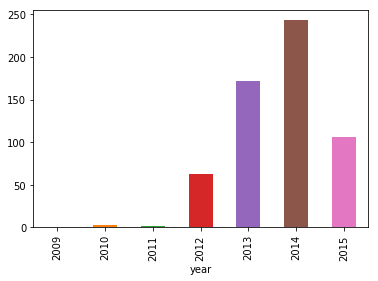

In [26]:
train_data[(train_data.fare_amount>56) & (train_data.fare_amount<58)].groupby(['year']).size().plot.bar()

看频率异常是否与年份有关，以下同理

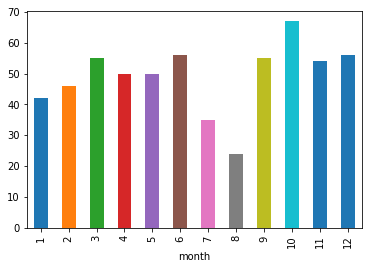

In [27]:
train_data[(train_data.fare_amount>56) & (train_data.fare_amount<58)].groupby(['month']).size().plot.bar()

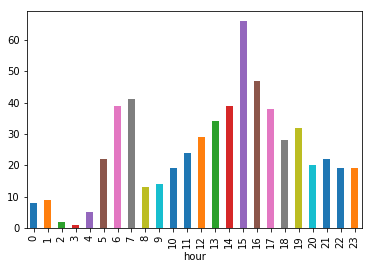

In [28]:
train_data[(train_data.fare_amount>56) & (train_data.fare_amount<58)].groupby(['hour']).size().plot.bar()

In [29]:
train_data['weekday'] = train_data.time.map(lambda x : x.weekday())

突然想起于是把周几也加进去

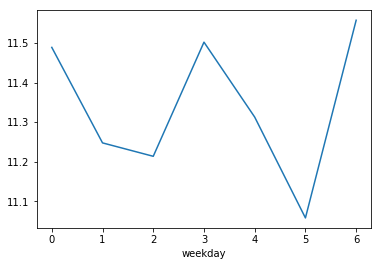

In [30]:
train_data.groupby(['weekday']).fare_amount.mean().plot.line()

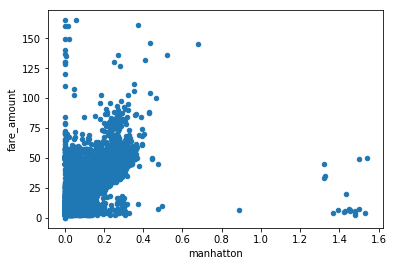

In [31]:
train_data.plot.scatter(x='manhatton',y='fare_amount')

曼哈顿距离与价格的散点图。x=0这有几乎垂直的不合理的数据。
没走多远但价格却异常的高，可以过滤掉

In [32]:
a = train_data.manhatton.map(lambda x : 100000*x)

先试着放大横轴

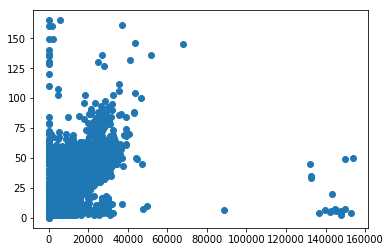

In [33]:
plt.scatter(a,train_data.fare_amount)

In [34]:
dada = train_data[train_data.manhatton>0.01]

先试着用一个dada复制数据来实验下筛选阈值

In [35]:
b = a[a>1000]

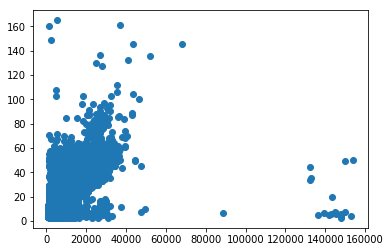

In [36]:
plt.scatter(b,dada.fare_amount)

In [37]:
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

In [38]:
dada['jfk'] = (dada.dropoff_longitude-jfk[0])**2  +  (dada.dropoff_latitude-jfk[1])**2

dada['nyc'] = (dada.dropoff_longitude-nyc[0])**2  +  (dada.dropoff_latitude-nyc[1])**2

D:\Anaconda\envs\py3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\envs\py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


t['jfk'] = (t.dropoff_longitude-jfk[0])**2  +  (t.dropoff_latitude-jfk[1])**2

t['nyc'] = (t.dropoff_longitude-nyc[0])**2  +  (t.dropoff_latitude-nyc[1])**2

plt.scatter(x=t[(t.jfk<0.0001)].manhatton,y=t[(t.jfk<0.0001)].fare_amount)

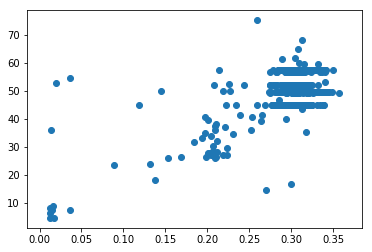

In [39]:
plt.scatter(x=dada[(dada.jfk<0.0001)].manhatton,y=dada[(dada.jfk<0.0001)].fare_amount)

到达jfk机场的距离和价格关系

plt.scatter(x=t[(t.nyc<0.0001)].manhatton,y=t[(t.nyc<0.0001)].fare_amount)

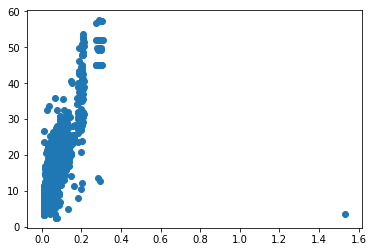

In [40]:
plt.scatter(x=dada[(dada.nyc<0.0001)].manhatton,y=dada[(dada.nyc<0.0001)].fare_amount)

到达jfk机场的距离和价格关系，但[1.4,1.6]区间这个有点假，距离那么远却基本不要钱。这应该也算噪音，试着把它去掉

In [41]:
dada[(dada.manhatton>1.4)&(dada.nyc<0.0001)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhatton,time,hour,year,month,weekday,jfk,nyc
58224,2010-04-30 20:53:02.0000001,3.7,2010-04-30 20:53:02 UTC,-73.137393,41.366138,-74.010581,40.709605,1,1.529721,2010-04-30 20:53:02,20,2010,4,4,0.05643,0.000038


找出这个数据id=58224，删了它

In [42]:
dada.drop([58224],inplace=True)

D:\Anaconda\envs\py3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
dada['is_jfk'] = dada.jfk.apply(lambda x : 1 if x<0.0001 else 0)

dada['is_nyc'] = dada.nyc.apply(lambda x : 1 if x<0.0001 else 0)

D:\Anaconda\envs\py3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\envs\py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


判断目的地是否处于jfk或者nyc附近，1表示在，否则0

In [44]:
train_data = dada

In [45]:
train_data.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhatton,time,hour,year,month,weekday,jfk,nyc,is_jfk,is_nyc
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.011742,2009-06-15 17:26:21,17,2009,6,0,0.008166,0.027156,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.107481,2010-01-05 16:52:16,16,2010,1,1,0.057826,0.005337,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.019212,2011-08-18 00:35:00,0,2011,8,3,0.055009,0.001554,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.029386,2012-04-21 04:30:42,4,2012,4,5,0.056804,0.002149,0,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.027194,2010-03-09 07:51:00,7,2010,3,1,0.049914,0.007317,0,0
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,0.054675,2011-01-06 09:50:45,9,2011,1,3,0.049366,0.003064,0,0
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,0.019380,2012-11-20 20:35:00,20,2012,11,1,0.051265,0.003630,0,0
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,0.061885,2012-01-04 17:22:00,17,2012,1,2,0.054635,0.001626,0,0
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,0.018299,2012-12-03 13:10:00,13,2012,12,0,0.052110,0.000482,0,0
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,0.035147,2009-09-02 01:11:00,1,2009,9,2,0.056803,0.002154,0,0


In [46]:
test_data.head()

test_data['time']=pd.to_datetime(test_data.pickup_datetime)
test_data['hour'] = test_data.time.map(lambda x : x.hour)
test_data['year'] = test_data.time.map(lambda x : x.year)
test_data['month'] = test_data.time.map(lambda x : x.month)
test_data['weekday'] = test_data.time.map(lambda x : x.weekday())

test_data['jfk'] = (test_data.dropoff_longitude-jfk[0])**2  +  (test_data.dropoff_latitude-jfk[1])**2

test_data['nyc'] = (test_data.dropoff_longitude-nyc[0])**2  +  (test_data.dropoff_latitude-nyc[1])**2

test_data['is_jfk'] = test_data.jfk.apply(lambda x : 1 if x<0.0001 else 0)

test_data['is_nyc'] =test_data.nyc.apply(lambda x : 1 if x<0.0001 else 0)

In [47]:
test_data[test_data.is_jfk==1]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhatton,time,hour,year,month,weekday,jfk,nyc,is_jfk,is_nyc
188,2013-04-25 16:10:04.0000001,2013-04-25 16:10:04 UTC,-73.971341,40.751362,-73.776249,40.645615,1,0.300839,2013-04-25 16:10:04,16,2013,4,3,3.777705e-05,0.057664,1,0
352,2009-06-10 16:55:00.000000144,2009-06-10 16:55:00 UTC,-73.782160,40.644255,-73.782175,40.644248,1,0.000022,2009-06-10 16:55:00,16,2009,6,2,8.845042e-09,0.055160,1,0
530,2011-06-24 12:03:00.000000149,2011-06-24 12:03:00 UTC,-73.979467,40.754977,-73.790123,40.646853,1,0.297468,2011-06-24 12:03:00,12,2011,6,4,6.963868e-05,0.051302,1,0
546,2014-06-15 07:06:00.00000035,2014-06-15 07:06:00 UTC,-73.987240,40.760167,-73.785060,40.643170,1,0.319177,2014-06-15 07:06:00,7,2014,6,6,9.046327e-06,0.054027,1,0
551,2014-06-15 07:06:00.00000039,2014-06-15 07:06:00 UTC,-73.967057,40.767152,-73.776512,40.645057,1,0.312640,2014-06-15 07:06:00,7,2014,6,6,3.339933e-05,0.057620,1,0
558,2014-06-15 07:06:00.00000017,2014-06-15 07:06:00 UTC,-73.983460,40.760602,-73.789722,40.646892,1,0.307448,2014-06-15 07:06:00,7,2014,6,6,6.367411e-05,0.051470,1,0
618,2014-03-17 16:07:56.0000002,2014-03-17 16:07:56 UTC,-73.955378,40.772788,-73.782317,40.644248,1,0.301601,2014-03-17 16:07:56,16,2014,3,0,1.559794e-08,0.055097,1,0
1170,2010-09-29 16:43:00.0000003,2010-09-29 16:43:00 UTC,-73.969410,40.759957,-73.790098,40.646857,1,0.292412,2010-09-29 16:43:00,16,2010,9,2,6.926577e-05,0.051312,1,0
1205,2010-09-29 16:43:00.00000087,2010-09-29 16:43:00 UTC,-73.978928,40.736373,-73.782682,40.644133,1,0.288486,2010-09-29 16:43:00,16,2010,9,2,2.125291e-07,0.054949,1,0
1390,2012-11-03 17:11:00.00000073,2012-11-03 17:11:00 UTC,-73.990205,40.761912,-73.787582,40.644872,1,0.319663,2012-11-03 17:11:00,17,2012,11,5,2.922471e-05,0.052678,1,0


In [48]:
train_data.drop(columns=['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','time','jfk','nyc'],inplace=True)

In [49]:
test_data.drop(columns=['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','time','jfk','nyc'],inplace=True)

In [50]:
train_data.head(20)

,fare_amount,passenger_count,manhatton,hour,year,month,weekday,is_jfk,is_nyc
0,4.5,1,0.011742,17,2009,6,0,0,0
1,16.9,1,0.107481,16,2010,1,1,0,0
2,5.7,2,0.019212,0,2011,8,3,0,0
3,7.7,1,0.029386,4,2012,4,5,0,0
4,5.3,1,0.027194,7,2010,3,1,0,0
5,12.1,1,0.054675,9,2011,1,3,0,0
6,7.5,1,0.019380,20,2012,11,1,0,0
7,16.5,1,0.061885,17,2012,1,2,0,0
8,9.0,1,0.018299,13,2012,12,0,0,0
9,8.9,2,0.035147,1,2009,9,2,0,0


In [51]:
mean_man = train_data.manhatton.mean()

std_man = train_data.manhatton.std()

train_data['nomal_manh'] = train_data.manhatton.map(lambda x : (x-mean_man)/std_man)

test_data['nomal_manh'] = test_data.manhatton.map(lambda x : (x-mean_man)/std_man)

train_data['nomal_year'] = train_data.year.map(lambda x : x-2009)
test_data['nomal_year'] = test_data.year.map(lambda x : x-2009)

test_data.head()

del test_data['year']
del test_data['manhatton']
del train_data['year']
del train_data['manhatton']

In [52]:
train_data.head()

,fare_amount,passenger_count,hour,month,weekday,is_jfk,is_nyc,nomal_manh,nomal_year
0,4.5,1,17,6,0,0,0,-0.672159,0
1,16.9,1,16,1,1,0,0,1.082405,1
2,5.7,2,0,8,3,0,0,-0.535260,2
3,7.7,1,4,4,5,0,0,-0.348806,3
4,5.3,1,7,3,1,0,0,-0.388978,1


In [53]:
train_data['nomal_hour'] = train_data.hour.map(lambda x : (x-12)/12)
train_data['nomal_month'] = train_data.month.map(lambda x : (x-6)/6)
train_data['nomal_weekday'] = train_data.weekday.map(lambda x : (x-3.5)/3.5)
test_data['nomal_hour'] = test_data.hour.map(lambda x : (x-12)/12)
test_data['nomal_month'] = test_data.month.map(lambda x : (x-6)/6)
test_data['nomal_weekday'] = test_data.weekday.map(lambda x : (x-3.5)/3.5)

In [54]:
test_data.drop(columns=['hour','month','weekday'],inplace = True)
train_data.drop(columns=['hour','month','weekday'],inplace = True)

In [55]:
train_data

,fare_amount,passenger_count,is_jfk,is_nyc,nomal_manh,nomal_year,nomal_hour,nomal_month,nomal_weekday
0,4.50,1,0,0,-0.672159,0,0.416667,0.000000,-1.000000
1,16.90,1,0,0,1.082405,1,0.333333,-0.833333,-0.714286
2,5.70,2,0,0,-0.535260,2,-1.000000,0.333333,-0.142857
3,7.70,1,0,0,-0.348806,3,-0.666667,-0.333333,0.428571
4,5.30,1,0,0,-0.388978,1,-0.416667,-0.500000,-0.714286
5,12.10,1,0,0,0.114654,2,-0.250000,-0.833333,-0.142857
6,7.50,1,0,0,-0.532181,3,0.666667,0.833333,-0.714286
7,16.50,1,0,0,0.246788,3,0.416667,-0.833333,-0.428571
8,9.00,1,0,0,-0.551992,3,0.083333,1.000000,-1.000000
9,8.90,2,0,0,-0.243227,0,-0.916667,0.500000,-0.428571


# 数据处理后，开始建模= =

In [56]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=8))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2304      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
__________

model = Sequential()

model.add(
    Dense(64,
          activation='relu',
          input_dim=8,
          kernel_initializer='random_uniform')
)

model.add(
    Dense(64,
          activation='relu',
          kernel_initializer='random_uniform')
)
model.add(
    Dense(32,
          activation='relu',
          kernel_initializer='random_uniform')
)
model.add(
    Dense(16,
          activation='relu',
          kernel_initializer='random_uniform')
)
model.add(
    Dense(8,
          activation='relu',
          kernel_initializer='random_uniform')
)
model.add(
    Dense(1)
)
model.summary()

model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [58]:
y_train = train_data['fare_amount'].values

In [59]:
x_train = train_data.drop(['fare_amount'],axis=1).values

In [60]:
x_test = test_data.values

In [61]:
train_data.head()

,fare_amount,passenger_count,is_jfk,is_nyc,nomal_manh,nomal_year,nomal_hour,nomal_month,nomal_weekday
0,4.5,1,0,0,-0.672159,0,0.416667,0.000000,-1.000000
1,16.9,1,0,0,1.082405,1,0.333333,-0.833333,-0.714286
2,5.7,2,0,0,-0.535260,2,-1.000000,0.333333,-0.142857
3,7.7,1,0,0,-0.348806,3,-0.666667,-0.333333,0.428571
4,5.3,1,0,0,-0.388978,1,-0.416667,-0.500000,-0.714286


train_data.to_csv("D:/DL_data/Taxi/traindata.csv",index=False)
test_data.to_csv("D:/DL_data/Taxi/testdata.csv",index=False)
#这是当时为了转发做的存储训练数据的代码，运行则不需要

In [62]:
test_data.head()

,passenger_count,is_jfk,is_nyc,nomal_manh,nomal_year,nomal_hour,nomal_month,nomal_weekday
0,1,0,0,-0.372741,6,0.083333,-0.833333,-0.714286
1,1,0,0,-0.303809,6,0.083333,-0.833333,-0.714286
2,1,0,0,-0.740902,2,-0.083333,0.666667,0.428571
3,1,0,0,-0.420756,3,0.750000,1.000000,0.428571
4,1,0,0,0.356418,3,0.750000,1.000000,0.428571


passenger_count  乘客数
manhatton qi'dian曼哈顿距离
hour	
year	
month	
weekday	
is_jfk	
is_nyc

In [ ]:
model.fit(x_train,y_train,batch_size=32,epochs=20)

Epoch 1/20
88267/88267 [==============================] - 8s 87us/step - loss: 49.4256 - mean_absolute_error: 4.6318
Epoch 2/20
88267/88267 [==============================] - 7s 83us/step - loss: 20.2003 - mean_absolute_error: 2.7110
Epoch 3/20
88267/88267 [==============================] - 7s 74us/step - loss: 19.4971 - mean_absolute_error: 2.6787
Epoch 4/20
88267/88267 [==============================] - 6s 69us/step - loss: 19.5279 - mean_absolute_error: 2.6837
Epoch 5/20
88267/88267 [==============================] - 6s 70us/step - loss: 19.2427 - mean_absolute_error: 2.6672
Epoch 6/20
88267/88267 [==============================] - 6s 70us/step - loss: 19.0258 - mean_absolute_error: 2.6528
Epoch 7/20
88267/88267 [==============================] - 6s 72us/step - loss: 19.0629 - mean_absolute_error: 2.6375
Epoch 8/20
88267/88267 [==============================] - 6s 66us/step - loss: 18.9994 - mean_absolute_error: 2.6497
Epoch 9/20
88267/88267 [==============================] - 6s 65u

In [ ]:
y_predict = model.predict(x_test)

In [ ]:
y_predict.astype

In [ ]:
te = pd.read_csv("D:/DL_data/Taxi/test.csv")

In [ ]:
y_predict = y_predict.tolist()

In [ ]:
q = []
for i in x.fare_amount:
    for j in i:
        q.append(j)

In [ ]:
q

In [ ]:
x = pd.DataFrame({'key':te.key,'fare_amount':q})

x.head()

In [ ]:
x.to_csv('prediction_fare.csv',index = False)